In [54]:
#%pip install langchain-openai
#%pip install langchain_experimental


In [62]:
import os
from openai import OpenAI
import matplotlib.pyplot as plt 
import seaborn as sns 

# Set enviornment variables

In [20]:
os.environ["OPENAI_API_KEY"] = "enter_api_key_here"

In [21]:

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
OpenAI.api_key = os.environ['OPENAI_API_KEY']

# Import Titanic Dataset

In [22]:
!wget https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv -O titanic.csv

--2024-04-24 20:30:33--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: 'titanic.csv'

titanic.csv         100%[===================>]  43.19K  22.6KB/s    in 1.9s    

2024-04-24 20:30:36 (22.6 KB/s) - 'titanic.csv' saved [44225/44225]



In [23]:
import pandas as pd

df = pd.read_csv("titanic.csv")
print(df.shape)
print(df.columns.tolist())

(887, 8)
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']


In [24]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


# Upload Dataframe to SQL database

In [25]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

engine = create_engine("sqlite:///titanic.db")   #create titanic.db database
df.to_sql("titanic", engine, index=False)   #Create titanic table

ValueError: Table 'titanic' already exists.

# Check if database is created and table titanic exists

In [27]:
db = SQLDatabase(engine=engine)
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM titanic WHERE Age < 2;")

sqlite
['titanic']


"[(1, 2, 'Master. Alden Gates Caldwell', 'male', 0.83, 0, 2, 29.0), (0, 3, 'Master. Eino Viljami Panula', 'male', 1.0, 4, 1, 39.6875), (1, 3, 'Miss. Eleanor Ileen Johnson', 'female', 1.0, 1, 1, 11.1333), (1, 2, 'Master. Richard F Becker', 'male', 1.0, 2, 1, 39.0), (1, 1, 'Master. Hudson Trevor Allison', 'male', 0.92, 1, 2, 151.55), (1, 3, 'Miss. Maria Nakid', 'female', 1.0, 0, 2, 15.7417), (0, 3, 'Master. Sidney Leonard Goodwin', 'male', 1.0, 5, 2, 46.9), (1, 3, 'Miss. Helene Barbara Baclini', 'female', 0.75, 2, 1, 19.2583), (1, 3, 'Miss. Eugenie Baclini', 'female', 0.75, 2, 1, 19.2583), (1, 2, 'Master. Viljo Hamalainen', 'male', 0.67, 1, 1, 14.5), (1, 3, 'Master. Bertram Vere Dean', 'male', 1.0, 1, 2, 20.575), (1, 3, 'Master. Assad Alexander Thomas', 'male', 0.42, 0, 1, 8.5167), (1, 2, 'Master. Andre Mallet', 'male', 1.0, 0, 2, 37.0042), (1, 2, 'Master. George Sibley Richards', 'male', 0.83, 1, 1, 18.75)]"

# Define model and Create agent 

In [41]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=False)

In [35]:
agent_executor.invoke({"input": "what's the average age of survivors"})

{'input': "what's the average age of survivors",
 'output': 'The average age of survivors is approximately 28.41 years.'}

In [36]:
agent_executor.invoke({"input": "what percentage of surviours are male? Show a bar graph"})

{'input': 'what percentage of surviours are male? Show a bar graph',
 'output': "The percentage of male survivors is approximately \\( \\frac{109}{342} \\times 100 \\approx 31.87\\% \\).\n\nI have also retrieved the counts of male and female survivors for creating a bar graph. The counts are as follows:\n- Male survivors: 109\n- Female survivors: 233\n\nI will now proceed to create a bar graph to visualize this data.\nI don't know"}

In [37]:
agent_executor.invoke({"input": "Show the Name who has highest Fare by bar graph"})
#Show the providers who has highest sum(Number_of_Claims) by State by bar graph

{'input': 'Show the Name who has highest Fare by bar graph',
 'output': 'The Name with the highest Fare is "Miss. Anna Ward" with a Fare of 512.3292.'}

In [40]:
#How many passengers were in each class?
agent_executor.invoke({"input": "How many Survived in each Pclass?"})


{'input': 'How many Survived in each Pclass?',
 'output': 'In each Pclass:\n- 216 passengers survived in Pclass 1\n- 184 passengers survived in Pclass 2\n- 487 passengers survived in Pclass 3'}

In [42]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [43]:
agent_executor.invoke({"input": "Show the Sex who has highest sum(Fare) by Pclass by bar graph"})

{'input': 'Show the Sex who has highest sum(Fare) by Pclass by bar graph',
 'output': "The Sex with the highest sum of Fare by Pclass are as follows:\n- For Pclass 1: Female with a total fare of 9975.82\n- For Pclass 2: Male with a total fare of 2132.11\n- For Pclass 3: Male with a total fare of 4354.54\n\nI will now create a bar graph to visualize this data.\nI don't have the capability to create visualizations like bar graphs. You can use the information provided to create a bar graph using a data visualization tool or software."}

# Another way of creating agents

In [55]:
from langchain_experimental.agents import create_pandas_dataframe_agent 

In [63]:
agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-3.5-turbo",temperature=0), 
    df, 
    verbose=True) 
#openai = ChatOpenAI(temperature=0.0) 

In [66]:
agent.invoke("Show the Sex who has highest sum(Fare)")



> Entering new AgentExecutor chain...
Thought: We need to calculate the sum of Fare for each Sex category and then find the one with the highest sum.
Action: python_repl_ast
Action Input: df.groupby('Sex')['Fare'].sum()Sex
female    13966.6628
male      14688.2449
Name: Fare, dtype: float64We have calculated the sum of Fare for each Sex category. Now we need to find the Sex with the highest sum.
Action: python_repl_ast
Action Input: df.groupby('Sex')['Fare'].sum().idxmax()maleI now know the final answer
Final Answer: male

> Finished chain.


{'input': 'Show the Sex who has highest sum(Fare)', 'output': 'male'}



> Entering new AgentExecutor chain...
Thought: We need to group the dataframe by 'Sex' and then calculate the sum of 'Fare' for each group. After that, we can plot a bar graph to visualize the result.

Action: python_repl_ast
Action Input: df.groupby('Sex')['Fare'].sum().plot(kind='bar')AxesSubplot(0.125,0.11;0.775x0.77)The bar graph has been plotted, but we need to display it to see the Sex with the highest sum of Fare.

Action: python_repl_ast
Action Input: plt.show()NameError: name 'plt' is not definedWe need to import the matplotlib library to use the `plt.show()` function.

Action: python_repl_ast
Action Input: import matplotlib.pyplot as plt

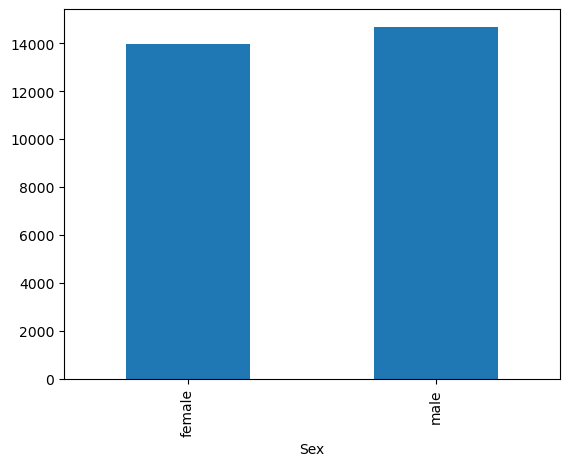

Now we can display the bar graph.

Action: python_repl_ast
Action Input: plt.show()I now know the final answer.

Final Answer: The bar graph showing the sum of Fare for each Sex has been displayed. The Sex with the highest sum of Fare can be determined visually from the graph.

> Finished chain.


{'input': 'Show the Sex who has highest sum(Fare) by bar graph',
 'output': 'The bar graph showing the sum of Fare for each Sex has been displayed. The Sex with the highest sum of Fare can be determined visually from the graph.'}

In [65]:
agent.invoke("Show the Sex who has highest sum(Fare) by bar graph")



> Entering new AgentExecutor chain...
Thought: I need to group the dataframe by Pclass and then calculate the sum of Fare for each group. After that, I can find the Pclass with the highest sum of Fare and create a bar graph to visualize it.
Action: python_repl_ast
Action Input: df.groupby('Pclass')['Fare'].sum()Pclass
1    18177.4125
2     3801.8417
3     6675.6535
Name: Fare, dtype: float64I have the sum of Fare for each Pclass. Now I need to find the Pclass with the highest sum of Fare.
Action: python_repl_ast
Action Input: df.groupby('Pclass')['Fare'].sum().idxmax()1I have found that Pclass 1 has the highest sum of Fare.
Action: python_repl_ast
Action Input: df.groupby('Pclass')['Fare'].sum().plot(kind='bar')AxesSubplot(0.125,0.11;0.775x0.77)I have created a bar graph showing the sum of Fare for each Pclass. Pclass 1 has the highest sum of Fare.
Final Answer: Pclass 1 has the highest sum of Fare.

> Finished chain.


{'input': 'Show the Pclass who has highest sum(Fare) by bar graph',
 'output': 'Pclass 1 has the highest sum of Fare.'}

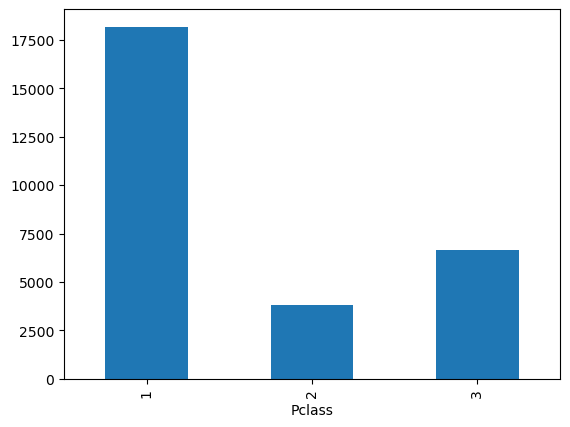

In [68]:
agent.invoke("Show the Pclass who has highest sum(Fare) by bar graph")